# predicting the health uninsured in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import numpy as np
from dotenv import load_dotenv
from statsmodels.graphics.mosaicplot import mosaic
import utils

Load the cleaned data from csv file and the code dictionary for the column names.

In [2]:
nsamples = 500
datadir  = os.path.join(os.getcwd(),"data")
fname    = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '.csv')
df       = pd.read_csv(fname,low_memory=False)
codedict = utils.getCodeDictionary()
df

,Unnamed: 0,index,HHLANP,FBATHP,DRIVESP,WGTP23,WGTP22,WGTP25,WGTP24,FWATP,...,FOD1P,FMARP,SOCP,FSMOCP,FDOUTP,PERNP,SCH,TEL,TEN,STATE
0,0,35900,9500,0,0,225,61,246,81,0,...,2304,0,151299,1,0,29200,1,1,3,AL
1,1,13014,9500,0,0,48,55,42,16,0,...,1099,0,-1,0,0,-10001,2,1,1,AL
2,2,44316,9500,1,0,91,132,93,160,1,...,1099,0,412010,0,0,2600,2,1,3,AL
3,3,26573,9500,0,0,60,77,53,57,0,...,1099,0,-1,1,0,0,1,1,2,AL
4,4,27452,9500,0,0,25,94,123,34,0,...,1099,0,-1,0,0,-10001,3,1,3,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,25495,1642,9500,0,1,152,146,127,146,0,...,1099,0,513091,0,0,35000,2,1,2,WY
25496,25496,1443,9500,0,0,64,68,60,123,0,...,1099,0,119013,0,0,10000,1,1,3,WY
25497,25497,2470,9500,0,1,452,344,300,301,0,...,1099,0,439061,1,0,25600,1,2,4,WY
25498,25498,3255,9500,0,0,159,155,40,38,0,...,1099,0,-1,0,0,0,1,1,1,WY


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

We know that there are a number of categorical variables in the dataset, as well as numerical variables. We can use the predictive power score (pps) to estimate the predictive power of each variable for our target variable. However, to use the predictive power score, we need to convert categorical variables to data type 'category.' 

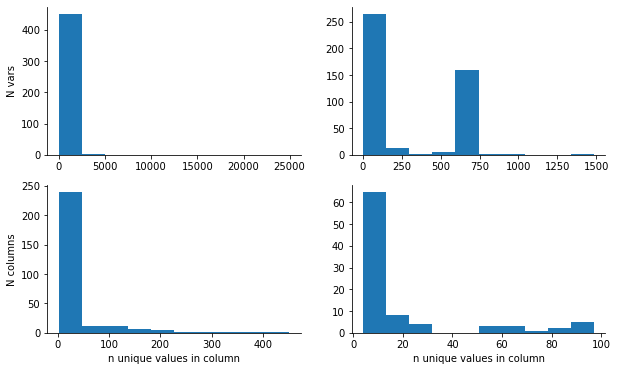

In [4]:
#try to identify categorical variables by considering number of unique values?
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.hist(df.nunique()) 
plt.ylabel('N vars')
plt.title('')
sns.despine()

plt.subplot(2,2,2)
plt.hist(df.nunique()[df.nunique().between(1,1500)])
sns.despine()

plt.subplot(2,2,3)
plt.hist(df.nunique()[df.nunique().between(1,500)])
sns.despine()
plt.xlabel('n unique values in column')
plt.ylabel('N columns')

plt.subplot(2,2,4)
plt.hist(df.nunique()[df.nunique().between(4,100)])
sns.despine()
plt.xlabel('n unique values in column')
plt.show()

In [5]:
# spot check info available for a variable that is very likely categorical (<=3 unique values)
cols = df.columns[df.nunique().between(2,3)]
dets = utils.variableDetails(cols[0])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Bathtub or shower allocation flag
values:
{'1': 'Yes', '0': 'No', '-1': 'N/A (GQ)'}


In [6]:
# spot check info available for a variable that is very likely numerical (> 500 unique values)
cols = df.columns[df.nunique().gt(800)]
dets = utils.variableDetails(cols[1])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Total person's income (signed, use ADJINC to adjust to constant dollars)
values:
{'-19999': 'N/A (less than 15 years old)', '-19998': 'Loss of $19998 or more (Rounded and bottom-coded components)', '0': 'None'}


We know that the index column comes from the index in the row from our api call. It is categorical and at this point we do not need it, so we can drop. 

In [7]:
df.drop('index',axis=1,inplace=True)

It looks like info on numerical values (like in the immediate cell above) includes a 'range' key to indicate the min and max of that numerical variable, while categorical variables do not include that information. Maybe we can use this to identify categorical/numerical variables. 

In [8]:
# call API for states in loop and save csv locally if it doesn't exist yet:
column_list = df.columns.tolist()
column_list.remove('STATE')
fname = os.path.join(datadir,'datatype_ncol' + str(df.shape[1]) + '.csv')
if os.path.exists(fname) == False:  
    range_key = list()
    info_from_api = list()
    n_unq_vals = list()
    for column in column_list:
        try: 
            dets = utils.variableDetails(column)
            range_key.append('range' in dets['values'].keys())
            info_from_api.append(True)
            n_unq_vals.append(df[column].nunique())
        except:
            range_key.append(False)
            info_from_api.append(False)
            n_unq_vals.append(df[column].nunique())
    datatype = pd.DataFrame({'var_name':column_list,'range_key':range_key,'n_unq_vals':n_unq_vals,'info_from_api':info_from_api})
    datatype.to_csv(fname)
else:
    print('')
    datatype = pd.read_csv(fname)

In [9]:
print('The number of columns in our main df should equal the number of rows in our datatype dataframe: ')
print('df column N:' + str(datatype.shape[1]))
print('datatype rows N:' + str(datatype.shape[0]))
print('The only vars where numerical info is not from the api:')
print(datatype[datatype.info_from_api == False]['var_name'])

The number of columns in our main df should equal the number of rows in our datatype dataframe: 
df column N:5
datatype rows N:454
The only vars where numerical info is not from the api:
339    SERIALNO
Name: var_name, dtype: object


We can do another check to see if this approach is adding up. Are there any variables coming out as categorical that have a very high number of unique values? Are any coming out as numerical that have very few unique values? 

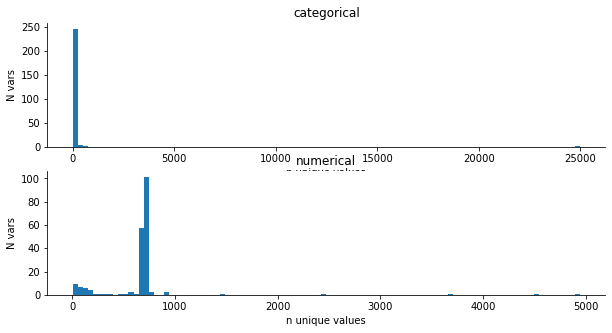

In [10]:
# now we can look at the distributions of N unique values for our columns again with our categorical/numerical labels
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==False],bins=100) 

plt.ylabel('N vars')
plt.xlabel('n unique values')
plt.title('categorical')
sns.despine()

plt.subplot(2,1,2)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==True],bins=100) 
plt.xlabel('n unique values')
plt.ylabel('N vars')

plt.title('numerical')
sns.despine()

plt.show()

In [11]:
# we can check our vars that lie on the unexpected extremes (low unique N, numerical):
print('var with min number of unique values that may be numerical:') 
min_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==True].idxmin()]

# get deets:
dets = utils.variableDetails(min_cat_row['var_name'])
print(dets)

var with min number of unique values that may be numerical:
{'name': 'RACNUM', 'label': 'Number of major race groups represented', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'range': [{'min': '1', 'max': '6', 'description': 'Race groups'}]}}


This is numerical, so the approach may be working..

In [12]:
# we can check our vars that lie on the unexpected extremes (high unique N, categorical)::
print('var with max number of unique values that may be categorical:') 
max_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==False].idxmax()]

print(max_cat_row)

# get deets:
dets = utils.variableDetails(max_cat_row['var_name'])
print(dets)

var with max number of unique values that may be categorical:
Unnamed: 0            339
var_name         SERIALNO
range_key           False
n_unq_vals          24974
info_from_api       False
Name: 339, dtype: object
{'name': 'SERIALNO', 'label': 'Housing unit/GQ person serial number', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP'}


This one also checks out. Now we can convert the datatypes in the main df.

In [13]:
datatype.set_index('var_name',inplace=True)

In [14]:
#convert the datatypes
print('converting data types...')
for index in datatype.index:
    if datatype.loc[index].range_key == False:
        df[index] = df[index].astype('category')

converting data types...


In [15]:
df.dtypes

HHLANP     category
FBATHP     category
DRIVESP    category
WGTP23        int64
WGTP22        int64
             ...   
PERNP         int64
SCH        category
TEL        category
TEN        category
STATE        object
Length: 455, dtype: object

Now we can make a copy of 'data_all' but this time fill in columns and values with more descriptive info.

In [16]:
verbdf = df.copy()
for column in verbdf:
    if column in codedict.keys():
        verbdf.rename(columns={column:codedict[column]},inplace=True)

In [32]:
for column in df:
    if df[column].dtype == 'category':
        dets = utils.variableDetails(column)
        if 'values' in dets.keys():
            newname = codedict[column]
            mapdict = dets['values']['item']
            key_list = mapdict.keys().astype("")
            for key in key_list:
                values = mapdict[key]
                mapdict.pop(key)
                mapdict[int(key)]=values
            verbdf[newname] = verbdf[newname].replace(mapdict)

RuntimeError: dictionary keys changed during iteration

{3: 'Rented',
 2: 'Owned Free And Clear',
 1: 'Owned with mortgage or loan (include home equity loans)',
 0: 'N/A  (GQ/vacant)',
 4: 'Occupied without payment of rent'}

RuntimeError: dictionary keys changed during iteration

Now with our columns converted into appropriate data types, we can compute the predictive power score between each column and our target variable, (health insured or not). 

In [17]:
# try predictive power score to see if there's a relationship between our target variable and other columns
target = 'HICOV'
predictors_df = pps.predictors(df, y=target,sorted=True,random_seed=123)
predictors_df.set_index('x',inplace=True)
predictors_df.head()

,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
x,,,,,,,,
FPRIVCOVP,FHICOVP,0.972462,classification,True,weighted F1,0.750933,0.993141,DecisionTreeClassifier()
FPUBCOVP,FHICOVP,0.560144,classification,True,weighted F1,0.750933,0.890446,DecisionTreeClassifier()
FHINS7P,FHICOVP,0.476870,classification,True,weighted F1,0.750933,0.869705,DecisionTreeClassifier()
FHINS6P,FHICOVP,0.466229,classification,True,weighted F1,0.750933,0.867055,DecisionTreeClassifier()
FHINS1P,FHICOVP,0.437580,classification,True,weighted F1,0.750933,0.859920,DecisionTreeClassifier()


In [18]:
print(df.shape)
print(predictors_df.shape) # the number of rows in predictors_df is off by one from the main df because it excludes our target variable

(25500, 456)
(455, 8)


In [19]:
def ecdf(x):
    y = list()
    for i in x:
        y.append(sum(x <= i)/len(x))
    return x,y

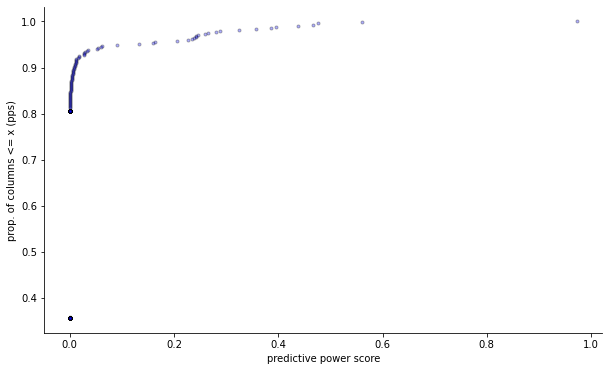

455
455


In [20]:
fig,ax=plt.subplots(figsize=(10,6))

x,y=ecdf(predictors_df['ppscore'])
ax.plot(x,y,marker='.',linestyle='None',color='None',markerfacecolor='blue',alpha=0.3)
sns.despine()
sns.color_palette('hls',8)
ax.set_xlabel('predictive power score')
ax.set_ylabel('prop. of columns <= x (pps)')

plt.show()

print(len(x))
print(len(y))

In [21]:
print('The proportion of points with a predictive power score of 0 is ' + str(y[len(y)-1]) + '.')
print('We can move forward by dropping the bottom ' + str(int(y[len(y)-1]*len(y))) + ' columns right off the bat.')

The proportion of points with a predictive power score of 0 is 0.35604395604395606.
We can move forward by dropping the bottom 162 columns right off the bat.


In [22]:
pps_0 = predictors_df[predictors_df['ppscore'] == 0].index
predictors_df = predictors_df.drop(index=pps_0,axis=0)
datatype = datatype.drop(index=pps_0,axis=0)
print(df.shape)
df = df.drop(pps_0,axis=1)
print(df.shape)
print(predictors_df.shape)

(25500, 456)
(25500, 294)
(293, 8)


It looks like one or two columns have a very high pps--going to check that there are not other medical insurance related columns being used as potential predictors. 

In [23]:
# check for target variable (health insured or not):
insurance_columns = list()
for key, value in codedict.items():
    if value.__contains__('insurance'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health care'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health service'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('health coverage'):
        print(key + " : " + value)
        insurance_columns.append(key)
    if value.__contains__('medi'):
        print(key + " : " + value)
        insurance_columns.append(key)         

PUBCOV : public health coverage recode
PRIVCOV : private health insurance coverage recode
FINSP : fire, hazard, flood insurance (yearly amount) allocation flag
FMRGIP : first mortgage payment includes fire, hazard, flood insurance allocation flag
HICOV : health insurance coverage recode
FPUBCOVP : public health coverage recode allocation flag
MRGI : first mortgage payment includes fire/hazard/flood insurance
FHICOVP : health insurance coverage recode allocation flag
FPRIVCOVP : private health insurance coverage recode allocation flag
FHINS7P : indian health service allocation flag
FHINS6P : va (enrolled for va health care) allocation flag
INSP : fire/hazard/flood insurance (yearly amount, use adjhsg to adjust insp to constant dollars)
HINS6 : va (enrolled for va health care)
HINS7 : indian health service
HINS1 : insurance through a current or former employer or union
HINS2 : insurance purchased directly from an insurance company
HINS3 : medicare, for people 65 and older, or people with

If a medical insurance column other than our target exists in our main dataframe we should drop it because in theory we shouldn't have this information.

In [24]:
# FHICOVP is our target, so not a predictor
# we already dropped 'HICOV' in data cleaning but we can check the other two vars
for i in insurance_columns:
    if i != target:
        if i in df.columns:
            df.drop(i,axis=1,inplace=True)
            predictors_df.drop(i,axis=0,inplace=True)
            datatype.drop(i,axis=0,inplace=True)

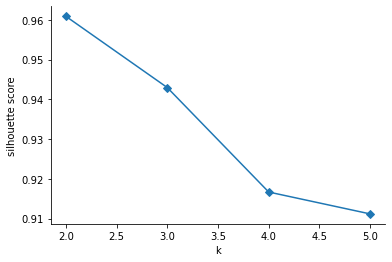

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pps = predictors_df[['ppscore']]
ks = [2,3,4,5]
silh_score = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pps)
    silh_score.append(silhouette_score(pps,kmeans.predict(pps)))
plt.plot(ks,silh_score,marker='D')
plt.xlabel("k")
plt.ylabel('silhouette score')
sns.despine()
plt.show()

In [26]:
k_best = ks[silh_score.index(max(silh_score))]
kmeans = KMeans(n_clusters=k_best)
kmeans.fit(pps)
clust = kmeans.labels_

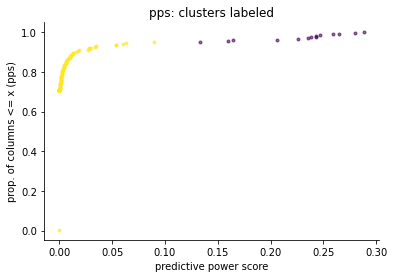

In [27]:
from matplotlib import cm
cmap=cm.get_cmap('viridis_r', k_best)
colors = cmap.colors

fig,ax=plt.subplots()
x,y=ecdf(predictors_df['ppscore'])
for i in range(len(x)):
    ax.plot(x[i],y[i],marker='.',linestyle='None',color=colors[clust[i]],markerfacecolor=colors[clust[i]],alpha=0.6)
sns.despine()
ax.set_xlabel('predictive power score')
ax.set_ylabel('prop. of columns <= x (pps)')
ax.set_title('pps: clusters labeled')
plt.show()

In [28]:
# check which cluster corresponds to higher pps
predictors_df['clust'] = clust
srtdf = predictors_df.groupby('clust').mean().sort_values('ppscore',ascending=True)

In [29]:
worst_clust = srtdf.index[0]

What are the dimensions of the df now? And what are these variables with the highest pp scores, out of curiousity?

In [30]:
pps_0 = predictors_df['ppscore'][clust==worst_clust].index
predictors_df = predictors_df.drop(index=pps_0,axis=1)
datatype = datatype.drop(index=pps_0,axis=1)
#print(predictors_df.shape)
#print(df.shape)
ndf = df.drop(pps_0,axis=1)
#print(ndf.shape)

(14, 9)
(25500, 273)
(25500, 15)


In [31]:
ndf.shape
ndf.rename(columns={'FHICOVP':'not_insured'},inplace=True)
datatype.rename(index={'FHICOVP':'not_insured'},inplace=True)

for column in ndf:
    if column == 'not_insured':
        continue
    else:
        ndf.rename(columns={column:codedict[column]},inplace=True)

In [32]:
for index in datatype.index:
    if index == 'not_insured':
        continue
    else:
        ndf.rename(index={index:codedict[index]},inplace=True)

In [33]:
ndf['insured']=ndf['not_insured'].map({0:1,1:0})
ndf.drop(columns=['not_insured'],inplace=True)

In [34]:
# save new data frame and predictors_df:
new_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns.csv')
ndf.to_csv(new_df_fname)
pred_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns_predictors_df.csv')
predictors_df.to_csv(pred_df_fname)
datatype_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_select_columns_datatype.csv')
datatype.to_csv(datatype_fname)

In [35]:
print('There are now ' + str(ndf.shape[1]) + ' columns.')

There are now 15 columns.


In [36]:
print(predictors_df.shape)
print(datatype.shape)
print(ndf.shape)

(14, 9)
(15, 4)
(25500, 15)


Now we can plot the distributions of our variables.

In [37]:
#what kind of variables are left? 
ndf.dtypes.unique()

array([CategoricalDtype(categories=[0, 1], ordered=False)], dtype=object)

Looks like they're all categorical at this point, with 0, 1 values. We can look at the counts of each variable separated by our target variable. 

In [38]:
df1 = pd.DataFrame(columns=ndf.columns)
df2 = pd.DataFrame(columns=ndf.columns)

for column in ndf.columns:
    df1[column] = ndf.groupby('insured')[column].value_counts(normalize=True)  # normalized counts
    df2[column] = ndf.groupby('insured')[column].value_counts(normalize=False) # counts
df1.head(10)

place of birth allocation flag  school enrollment allocation flag  \
insured                                                                        
1       0                        0.936926                           0.964375   
        1                        0.063074                           0.035625   
0       0                        0.718614                           0.759372   
        1                        0.281386                           0.240628   

           widowed in the past 12 months allocation flag  \
insured                                                    
1       0                                       0.974273   
        1                                       0.025727   
0       0                                       0.848082   
        1                                       0.151918   

           disability recode allocation flag  \
insured                                        
1       0                           0.940369   
        1                           0.059631   
0       0                           0.665867   
        1                           0.334133   

           vision difficulty allocation flag  citizenship allocation flag  \
insured                                                                     
1       0                           0.961075                     0.971787   
        1                           0.038925                     0.028213   
0       0                           0.715998                     0.761116   
        1                           0.284002                     0.238884   

           place of work state allocation flag  \
insured                                          
1       0                             0.963131   
        1                             0.036869   
0       0                             0.814080   
        1                             0.185920   

           language other than english allocation flag  \
insured                                                  
1       0                                     0.962988   
        1                                     0.037012   
0       0                                     0.748256   
        1                                     0.251744   

           self-care difficulty allocation flag  \
insured                                           
1       0                              0.949216   
        1                              0.050784   
0       0                              0.768309   
        1                              0.231691   

           hearing difficulty allocation flag  \
insured                                         
1       0                            0.953711   
        1                            0.046289   
0       0                            0.755231   
        1                            0.244769   

           mobility status allocation flag  \
insured                                      
1       0                         0.956915   
        1                         0.043085   
0       0                         0.745859   
        1                         0.254141   

           cognitive difficulty allocation flag  \
insured                                           
1       0                              0.955719   
        1                              0.044281   
0       0                              0.747602   
        1                              0.252398   

           ambulatory difficulty allocation flag  \
insured                                            
1       0                               0.954093   
        1                               0.045907   
0       0                               0.749564   
        1                               0.250436   

           independent living difficulty allocation flag  insured  
insured                                                            
1       0                                       0.961792      0.0  
        1                                       0.038208      1.

In [84]:
cs = pd.crosstab(ndf['insured'],ndf['place of birth allocation flag'])
cs.rename(columns={1:'yes',0:'no'},index={1:'yes',0:'no'},inplace=True)
cs

place of birth allocation flag,no,yes
insured,,
yes,19593,1319
no,3297,1291


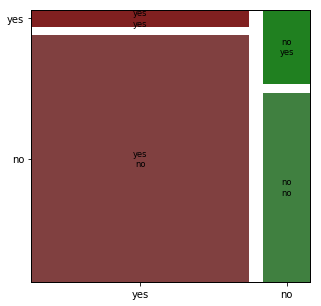

In [88]:
plt.rcParams["figure.figsize"] = (5,5)
mosaic(cs.stack(),gap=.05)
plt.show()

In [89]:
# import libraries
import os
import glob
import requests
import time
from dotenv import load_dotenv
# load variable names from census PUMS (public use microsample) API
load_dotenv()
API_KEY  = os.getenv('CENSUS_API_KEY')
host     = 'https://api.census.gov/data'
year     = 2019
dataset  = 'acs/acs1/pums/variables'
base_url = "/".join([host, str(year), dataset]) 
r        = requests.get(base_url)
rlists   = r.json()
code     = [item[0] for item in rlists if item[0].isupper()] #code in API
label    = [item[1].lower() for item in rlists if item[0].isupper()] # description for each code
nsamples = 500

codedict = {} # redudant with code, label but may make life easier later on
count    = 0
for lab in label:
    codedict[code[count]] = lab
    count += 1
# function to get data from Census API, Public Access MicroData Samples using list of codes (max 50), state id number 
def callCensusApi(API_KEY,year,select_codes,stateid):
    host     = 'https://api.census.gov/data'
    dataset  = 'acs/acs1/pums'
    query    = '?get='
    variable = ','.join(select_codes)
    base_url = "/".join([host, str(year), dataset]) + query + variable + '&for=state:' + stateid + '&key=' + API_KEY
    callbeg  = time.time()
    r        = requests.get(base_url) 
    colnames = variable.split(',')
    colnames.append('state')
    df       = pd.DataFrame(columns=colnames, data=r.json()[1:]) 
    tElapsed = time.time()-callbeg
    return (tElapsed,df)

# call api for more details on a specific variable
def variableDetails(codename):
    base_url = "/".join([host, str(year), dataset, codename + '.json']) 
    r        = requests.get(base_url)
    detail   = r.json()
    return detail
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [103]:
codename = get_keys_from_value(codedict,'place of birth allocation flag')
codename = codename[0]

<class 'str'>


In [105]:
for column in ndf:
    codename = get_keys_from_value(codedict,column)
    codename = codename[0]
    details = variableDetails(codename)
    print('from ' + codename)
    for key,value in details['values']['item'].items():
        print(key, ':', value)

from FPOBP
1 : Yes
0 : No
from FSCHP
0 : No
1 : Yes
from FMARHWP
0 : No
1 : Yes
from FDISP
0 : No
1 : Yes
from FDEYEP
0 : No
1 : Yes
from FCITP
0 : No
1 : Yes
from FPOWSP
1 : Yes
0 : No
from FLANXP
0 : No
1 : Yes
from FDDRSP
0 : No
1 : Yes
from FDEARP
1 : Yes
0 : No
from FMIGP
1 : Yes
0 : No
from FDREMP
1 : Yes
0 : No
from FDPHYP
0 : No
1 : Yes
from FDOUTP
1 : Yes
0 : No


IndexError: list index out of range